In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import datetime
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, LSTM
from keras.models import Sequential, Model,load_model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Input, Convolution1D, MaxPooling1D, GlobalMaxPooling1D
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import datetime
import pickle

Using TensorFlow backend.


In [10]:
final_data=pd.read_csv("final_data.csv")

### Subset

In [14]:
y1 = torch.tensor(final_data['unit_sales'].values.astype(np.float32))[:30000]
X1 = torch.tensor(final_data.drop('unit_sales', axis = 1).values.astype(np.float32))[:30000] 
dataset1 = TensorDataset(X1,y1) 

In [15]:
del final_data

In [18]:
train_set1, val_set1 = torch.utils.data.random_split(dataset1, [27000, 3000])
train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=1024)

In [19]:
del X1,y1

In [20]:
validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=3000)

In [21]:
class FirstNetwork_v1(nn.Module):
    def __init__(self,number_of_nodes):
        super().__init__()
        self.lin1 = nn.Linear(41,number_of_nodes)
        self.lin2 = nn.Linear(number_of_nodes, 1)
    
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = a1.relu()
        a2 = self.lin2(h1)
        return a2,a1

In [22]:
device = torch.device("cuda:0")

In [23]:
all_models_train_loss={}
all_models_val_loss={}
all_models_time={}

In [24]:
for i in range(12,26,3):
    print("Running Model with "+str(i)," nodes")
    all_models_train_loss[i]=[]
    all_models_val_loss[i]=[] 
    all_models_time[i]=[]
    for p in range(10):
#         torch.manual_seed(np.random.randint(0,1000000,1))
#         train_set1, val_set1 = torch.utils.data.random_split(dataset1, [4000,500])
#         train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=16)
#         validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=500)
        for c,v in validation_loader1:
            X_test1,y_test1=c,v
        print(str(p)+" Times Model Repeated")
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        model1=FirstNetwork_v1(number_of_nodes=i).to(device)
        criterion1 = nn.MSELoss()
        training_loss_model1=[]
        validation_loss_model1=[]
        time_model1=[]
        epochs = 100
        optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
        for epoch in range(epochs):
            training_loss_batch=[]
            validation_loss_batch=[]
            time_batch=[]
            for X_train, y_train in train_loader1:
                model1.train()
                optimizer1.zero_grad()
                X_train,y_train=X_train.to(device),y_train.to(device)
                start.record()
                output,features = model1(X_train)
                loss1 = criterion1(output, y_train.reshape(-1,1))
                loss1.backward()
                optimizer1.step()
                end.record()
                training_loss_batch.append(loss1.item())
                model1.eval()
                validation_loss_batch.append(criterion1(model1(X_test1.to(device))[0],y_test1.to(device).reshape(-1,1)).item())
                time_batch.append(start.elapsed_time(end))
            training_loss_model1.append(training_loss_batch)
            validation_loss_model1.append(validation_loss_batch)
            time_model1.append(time_batch)
        del model1
        torch.cuda.empty_cache()
        all_models_val_loss[i].append(validation_loss_model1)
        all_models_train_loss[i].append(training_loss_model1)
        all_models_time[i].append(time_model1)

Running Model with 12  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 15  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 18  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 21  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Mo

In [25]:
with open('final_model_train_sub.p', 'wb') as fp:
    pickle.dump(all_models_train_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('final_model_val_sub.p', 'wb') as fp:
    pickle.dump(all_models_val_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('final_model_time_sub.p', 'wb') as fp:
    pickle.dump(all_models_time, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
for m in sorted(all_models_val_loss.keys()):
    print(m,np.mean([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]),
         np.std([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]))

12 0.0002664797712727537 0.00011046131129218842
15 0.00025275753823397854 0.0001351862376277521
18 0.00025875776336761194 7.47801701389607e-05
21 0.00031482944991525813 5.4025986649131115e-05
24 0.00027724458475993877 7.90549885241888e-05


In [27]:
all_models_train_loss={}
all_models_val_loss={}
all_models_time={}

In [28]:
for i in range(12,26,3):
    print("Running Model with "+str(i)," nodes")
    all_models_train_loss[i]=[]
    all_models_val_loss[i]=[] 
    all_models_time[i]=[]
    for p in range(10):
#         torch.manual_seed(np.random.randint(0,1000000,1))
#         train_set1, val_set1 = torch.utils.data.random_split(dataset1, [4000,500])
#         train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=16)
#         validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=500)
        for c,v in validation_loader1:
            X_test1,y_test1=c,v
        print(str(p)+" Times Model Repeated")
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        model1=FirstNetwork_v1(number_of_nodes=i).to(device)
        criterion1 = nn.MSELoss()
        training_loss_model1=[]
        validation_loss_model1=[]
        time_model1=[]
        epochs = 100
        optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
        for epoch in range(epochs):
            training_loss_batch=[]
            validation_loss_batch=[]
            time_batch=[]
            for X_train, y_train in train_loader1:
                model1.train()
                optimizer1.zero_grad()
                X_train,y_train=X_train.to(device),y_train.to(device)
                start.record()
                output,features = model1(X_train)
                loss1 = criterion1(output, y_train.reshape(-1,1))
                loss1.backward()
                optimizer1.step()
                end.record()
                training_loss_batch.append(loss1.item())
                model1.eval()
                validation_loss_batch.append(criterion1(model1(X_test1.to(device))[0],y_test1.to(device).reshape(-1,1)).item())
                time_batch.append(start.elapsed_time(end))
            training_loss_model1.append(training_loss_batch)
            validation_loss_model1.append(validation_loss_batch)
            time_model1.append(time_batch)
        del model1
        torch.cuda.empty_cache()
        all_models_val_loss[i].append(validation_loss_model1)
        all_models_train_loss[i].append(training_loss_model1)
        all_models_time[i].append(time_model1)

Running Model with 12  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 15  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 18  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 21  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Mo

In [29]:
with open('final_model_train_sub1.p', 'wb') as fp:
    pickle.dump(all_models_train_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('final_model_val_sub1.p', 'wb') as fp:
    pickle.dump(all_models_val_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('final_model_time_sub1.p', 'wb') as fp:
    pickle.dump(all_models_time, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
for m in sorted(all_models_val_loss.keys()):
    print(m,np.mean([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]),
         np.std([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]))

12 1.7528342895847915e-05 1.1127816331484554e-05
15 1.282508579202436e-05 3.7273184601419584e-06
18 1.5731909570604333e-05 8.631606734575844e-06
21 1.1923776559409885e-05 2.5369203397385725e-06
24 1.274036764732079e-05 2.9490904225536445e-06


In [31]:
class FirstNetwork_v1(nn.Module):
    def __init__(self,number_of_nodes,number_of_nodes_2):
        super().__init__()
        self.lin1 = nn.Linear(41,number_of_nodes)
        self.lin2 = nn.Linear(number_of_nodes, number_of_nodes_2)
        self.lin3 = nn.Linear(number_of_nodes_2, 1)
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = a1.relu()
        a2 = self.lin2(h1)
        h2 = a2.relu()
        a3 = self.lin3(h2)
        return a3

In [32]:
all_models_train_loss={}
all_models_val_loss={}
all_models_time={}

In [33]:
for i in range(12,26,3):
    for l in range(4,9):
        print("Running Model with "+str(i)," nodes"," and ",str(l)," nodes")
        all_models_train_loss[i]=[]
        all_models_val_loss[i]=[] 
        all_models_time[i]=[]
        for p in range(10):
    #         torch.manual_seed(np.random.randint(0,1000000,1))
    #         train_set1, val_set1 = torch.utils.data.random_split(dataset1, [4000,500])
    #         train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=16)
    #         validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=500)
            for c,v in validation_loader1:
                X_test1,y_test1=c,v
            print(str(p)+" Times Model Repeated")
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            model1=FirstNetwork_v1(number_of_nodes=i,number_of_nodes_2=l).to(device)
            criterion1 = nn.MSELoss()
            training_loss_model1=[]
            validation_loss_model1=[]
            time_model1=[]
            epochs = 100
            optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
            for epoch in range(epochs):
                training_loss_batch=[]
                validation_loss_batch=[]
                time_batch=[]
                for X_train, y_train in train_loader1:
                    model1.train()
                    optimizer1.zero_grad()
                    X_train,y_train=X_train.to(device),y_train.to(device)
                    start.record()
                    output = model1(X_train)
                    loss1 = criterion1(output, y_train.reshape(-1,1))
                    loss1.backward()
                    optimizer1.step()
                    end.record()
                    training_loss_batch.append(loss1.item())
                    model1.eval()
                    validation_loss_batch.append(criterion1(model1(X_test1.to(device)),y_test1.to(device).reshape(-1,1)).item())
                    time_batch.append(start.elapsed_time(end))
                training_loss_model1.append(training_loss_batch)
                validation_loss_model1.append(validation_loss_batch)
                time_model1.append(time_batch)
            del model1
            torch.cuda.empty_cache()
            all_models_val_loss[i].append(validation_loss_model1)
            all_models_train_loss[i].append(training_loss_model1)
            all_models_time[i].append(time_model1)

Running Model with 12  nodes  and  4  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 12  nodes  and  5  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 12  nodes  and  6  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 12  nodes  and  7  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repea

In [34]:
with open('final_model_train_sub2.p', 'wb') as fp:
    pickle.dump(all_models_train_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('final_model_val_sub2.p', 'wb') as fp:
    pickle.dump(all_models_val_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('final_model_time_sub2.p', 'wb') as fp:
    pickle.dump(all_models_time, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
for m in sorted(all_models_val_loss.keys()):
    print(m,np.mean([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]),
         np.std([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]))

12 1.2264202582122784e-05 9.574286051866922e-06
15 1.0837473923351758e-05 2.8824547913123857e-06
18 1.0129264652884254e-05 9.93305796116239e-06
21 7.200872945152999e-06 2.635743846813195e-06
24 1.3908964343432604e-05 1.2989153766892294e-05


In [41]:
final_data=pd.read_csv("final_data.csv")

In [42]:
y1 = torch.tensor(final_data['unit_sales'].values.astype(np.float32))
X1 = torch.tensor(final_data.drop('unit_sales', axis = 1).values.astype(np.float32))
dataset1 = TensorDataset(X1,y1) 

In [43]:
del final_data

In [44]:
train_set1, val_set1 = torch.utils.data.random_split(dataset1, [1639252, 409813])
train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=2048)

In [45]:
del X1,y1

In [46]:
validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=409813)

In [47]:
for i,j in validation_loader1:
    X_test1,y_test1=i,j

In [51]:
class FinalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(41,21)
        self.lin2 = nn.Linear(21, 6)
        self.lin3 = nn.Linear(6, 1)
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = a1.relu()
        a2 = self.lin2(h1)
        h2 = a2.relu()
        a3 = self.lin3(h2)
        return a3

In [52]:
model1=FinalNetwork()

In [53]:
criterion1 = nn.MSELoss()

training_loss_model1=[]
validation_loss_model1=[]

epochs = 60
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)

for epoch in range(epochs):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        optimizer1.zero_grad()
        output = model1(X_train)
        loss1 = criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        validation_loss_batch.append(criterion1(model1(X_test1),y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%5==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

0
Training Loss: 0.00020114964839611436
Validation Loss: 0.00020166045030694586
5
Training Loss: 1.1606622843174499e-05
Validation Loss: 1.3721400024591725e-05
10
Training Loss: 1.0520595973157902e-05
Validation Loss: 1.2614817124914327e-05
15
Training Loss: 9.305804758766865e-06
Validation Loss: 1.1409669429886843e-05
20
Training Loss: 8.997427431062846e-06
Validation Loss: 1.109272219078723e-05
25
Training Loss: 8.747127816668502e-06
Validation Loss: 1.0818224904966308e-05
30
Training Loss: 8.482789001342387e-06
Validation Loss: 1.0547141995103378e-05
35
Training Loss: 8.58757622107818e-06
Validation Loss: 1.0615576569678175e-05
40
Training Loss: 8.398729185162633e-06
Validation Loss: 1.0451243892720448e-05
45
Training Loss: 8.532586451203653e-06
Validation Loss: 1.048043553540159e-05
50
Training Loss: 8.34106225149353e-06
Validation Loss: 1.0384936956668778e-05
55
Training Loss: 8.4767153148232e-06
Validation Loss: 1.0512080231766343e-05


In [54]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
for epoch in range(60,100):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        model1.train()
        optimizer1.zero_grad()
        output = model1(X_train)
        loss1 = criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        model1.eval()
        validation_loss_batch.append(criterion1(model1(X_test1),y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%5==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

60
Training Loss: 7.405512128065715e-06
Validation Loss: 9.45254499114317e-06
65
Training Loss: 7.338938721137054e-06
Validation Loss: 9.378879767200998e-06
70
Training Loss: 7.324215328403721e-06
Validation Loss: 9.366775114866007e-06
75
Training Loss: 7.314189619155491e-06
Validation Loss: 9.36452101456772e-06
80
Training Loss: 7.313068422814007e-06
Validation Loss: 9.359192068239261e-06
85
Training Loss: 7.316435161006443e-06
Validation Loss: 9.353386821465747e-06
90
Training Loss: 7.298885537331782e-06
Validation Loss: 9.341358682501509e-06
95
Training Loss: 7.294520305385028e-06
Validation Loss: 9.336034348367155e-06


In [55]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
for epoch in range(100,140):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        model1.train()
        optimizer1.zero_grad()
        output = model1(X_train)
        loss1 = criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        model1.eval()
        validation_loss_batch.append(criterion1(model1(X_test1),y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%5==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

100
Training Loss: 7.184197650811588e-06
Validation Loss: 9.223837550235656e-06
105
Training Loss: 7.172635707647306e-06
Validation Loss: 9.221143921010313e-06
110
Training Loss: 7.18031457709162e-06
Validation Loss: 9.222729691446625e-06
115
Training Loss: 7.169062952724768e-06
Validation Loss: 9.221078060422696e-06
120
Training Loss: 7.1686239824386515e-06
Validation Loss: 9.22237945196321e-06
125
Training Loss: 7.169421441529507e-06
Validation Loss: 9.219176990541625e-06
130
Training Loss: 7.171811989025904e-06
Validation Loss: 9.22115966741796e-06
135
Training Loss: 7.167065983383318e-06
Validation Loss: 9.21581434791397e-06


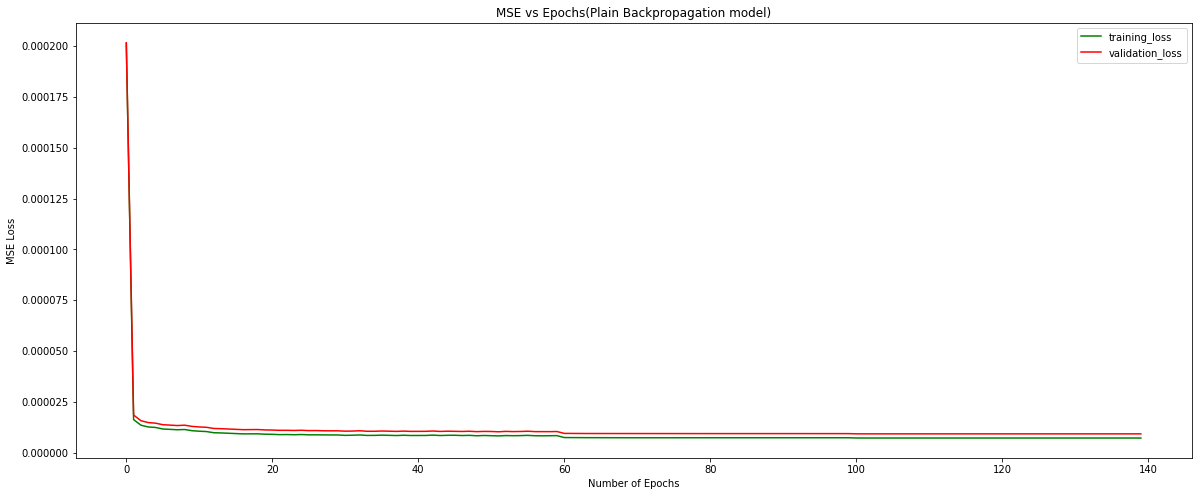

In [56]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len([np.mean(i) for i in training_loss_model1])),[np.mean(i) for i in training_loss_model1],'-g', label='training_loss')
plt.plot(np.arange(len([np.mean(i) for i in validation_loss_model1])),[np.mean(i) for i in validation_loss_model1],'-r', label='validation_loss')
plt.xlabel("Number of Epochs")
plt.ylabel("MSE Loss")
plt.title( "MSE vs Epochs(Plain Backpropagation model)")
plt.legend();

Skipping first 10 epochs


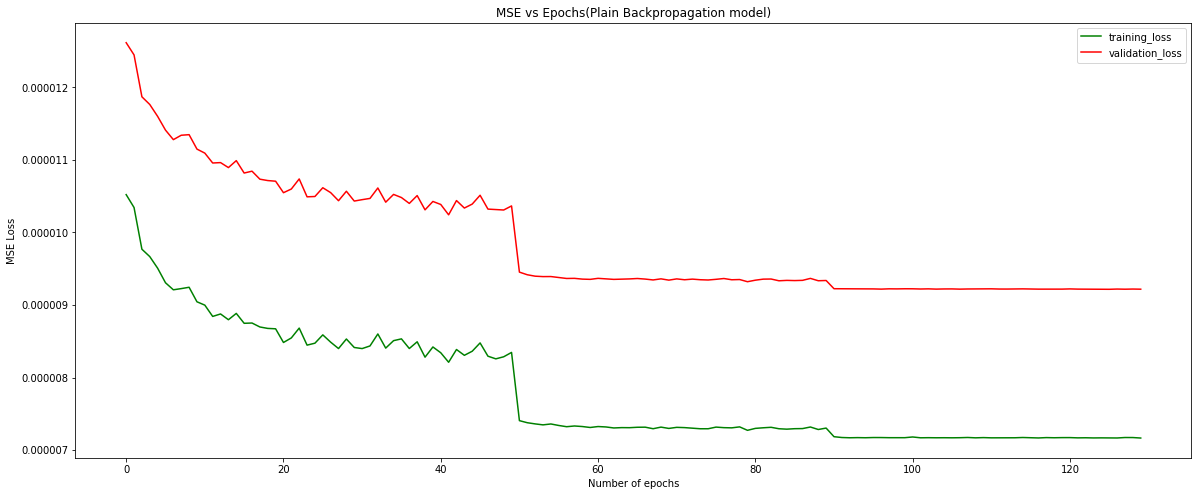

In [57]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len([np.mean(i) for i in training_loss_model1][10:])),[np.mean(i) for i in training_loss_model1][10:],'-g', label='training_loss')
plt.plot(np.arange(len([np.mean(i) for i in validation_loss_model1][10:])),[np.mean(i) for i in validation_loss_model1][10:],'-r', label='validation_loss')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.title( "MSE vs Epochs(Plain Backpropagation model)")
plt.legend();
print("Skipping first 10 epochs")

In [58]:
min(validation_loss_batch)

9.204271009366494e-06

In [59]:
torch.save(model1.state_dict(), "combined_model_final.pt")